Task Performance Measures for Cognitive Workload Evaluation using EEG signals

**BE Project Group id 6**

Swarali Belsare

Maitreyi Kale

Priya Ghayal

Aishwarya Gogate

In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


##### Importing Libraries

In [ ]:
from tensorflow.python.keras.layers import GlobalAveragePooling1D,Conv1D,Flatten,MaxPooling1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from tensorflow.python.keras.models import Model

import tensorflow.python.keras as keras
import tensorflow as tf
import numpy as np
import time

from tensorflow.python.keras.preprocessing import sequence

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense , BatchNormalization 
from tensorflow.python.keras.layers import GRU,LSTM

from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.callbacks import ModelCheckpoint , EarlyStopping

from statistics import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import confusion_matrix
from tabulate import tabulate


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##### Load prepared data

In [ ]:
X_train_hi = np.load('/content/drive/MyDrive/prepared_data/X_train_hi.npy')
X_test_hi = np.load('/content/drive/MyDrive/prepared_data/X_test_hi.npy')
y_train_hi = np.load('/content/drive/MyDrive/prepared_data/y_train_hi.npy')
y_test_hi = np.load('/content/drive/MyDrive/prepared_data/y_test_hi.npy')


X_train_hi_SMOTE = np.load('/content/drive/MyDrive/prepared_data/X_train_hi_SMOTE.npy')
y_train_hi_SMOTE = np.load('/content/drive/MyDrive/prepared_data/y_train_hi_SMOTE.npy')


X_train_lo = np.load('/content/drive/MyDrive/prepared_data/X_train_lo.npy')
X_test_lo = np.load('/content/drive/MyDrive/prepared_data/X_test_lo.npy')
y_train_lo = np.load('/content/drive/MyDrive/prepared_data/y_train_lo.npy')
y_test_lo = np.load('/content/drive/MyDrive/prepared_data/y_test_lo.npy')

X_train_lo_SMOTE = np.load('/content/drive/MyDrive/prepared_data/X_train_lo_SMOTE.npy')
y_train_lo_SMOTE = np.load('/content/drive/MyDrive/prepared_data/y_train_lo_SMOTE.npy')


##### CNN Model

In [ ]:
len(X_train_hi[0][0])

144000

In [ ]:
def cnn_evaluate(X_train,y_train,X_test,y_test,class_type,num_epochs,size):
    output = 0
    if class_type == 'levels':
      output = 3
    else:
      output = 2
    
    ad = Adam(0.01)
    model_cnn = Sequential()
    
    model_cnn.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(1,len(X_train[0][0])))) 
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size=1))

    model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu')) 
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size=1))

    model_cnn.add(GlobalMaxPooling1D())

    model_cnn.add(Flatten())
    model_cnn.add(Dense(32, activation='relu'))
    model_cnn.add(Dense(output, activation='softmax'))
    #model_cnn.summary()
    
    model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=ad, metrics=['accuracy'])
    hist = model_cnn.fit(X_train, y_train, validation_split=0.33,epochs=num_epochs, batch_size=size)
    _,accuracy_cnn = model_cnn.evaluate(X_test, y_test,batch_size = 5) 
    
    return model_cnn,hist,accuracy_cnn
    

##### GRU Model

In [ ]:
def gru_evaluate(X_train,y_train,X_test,y_test,class_type,num_epochs,size):
  if class_type == 'levels':
      output = 3
  else:
      output = 2


  ad = Adam(0.01)
  model_gru = Sequential()
  model_gru.add(GRU(128,return_sequences = True ,input_shape = (1,len(X_train[0][0]))))
  model_gru.add(GRU(64,return_sequences = True))
  model_gru.add(GRU(32,return_sequences = False))
  model_gru.add(Dense(output, activation='softmax'))

  #model_gru.summary()

  model_gru.compile(loss='sparse_categorical_crossentropy',optimizer = ad, metrics=['accuracy'])
  hist = model_gru.fit(X_train, y_train, validation_split=0.33,epochs=num_epochs, batch_size=size)
  _,accuracy_gru = model_gru.evaluate(X_test,y_test,batch_size = 5)
  return model_gru,hist,accuracy_gru
  

##### CNNGRU Model

In [ ]:
def cnngru_evaluate(X_train,y_train,X_test,y_test,class_type,num_epochs,size):
    if class_type == 'levels':
      output = 3
    else:

      output = 2
    ad = Adam(0.01)
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(1,len(X_train[0][0]))))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size=1))

    model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size=1))

    model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling1D(pool_size=1))

    model_gru = Sequential()
    
    model_gru.add(model_cnn)
    model_gru.add(GRU(64,return_sequences = True))
    model_gru.add(GRU(32,return_sequences = False))

    model_gru.add(Dense(output, activation='softmax'))
    #model_gru.summary()
    
    model_gru.compile(loss='sparse_categorical_crossentropy',optimizer = ad, metrics=['accuracy'])
    
    hist = model_gru.fit(X_train, y_train,validation_split=0.33, epochs=num_epochs, batch_size=size)
    accuracy = model_gru.evaluate(X_test,y_test,batch_size = 1)
    return model_gru,hist,accuracy
    

##### Performance Evaluation functions


In [ ]:
def plot_graph(hist,model_type):  

  # summarize history for accuracy
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title(model_type+' Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title(model_type+' Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def evaluation_report(model,X_test,y_test):
  predictions = model.predict(X_test, steps=5)
  y_true = y_test
  y_pred = np.argmax(predictions, axis=1)
  print(classification_report(y_true, y_pred, target_names=['Class0','Class1']))
  return y_true,y_pred

In [ ]:
def evaluation_metrics(y_true,y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  cm = confusion_matrix(y_true, y_pred)
  print('\nCONFUSION MATRIX\n',cm,'\n')
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  table = []
  table.append([sensitivity*100,specificity*100])
  print(tabulate(table, headers=["Sensitivity","Specificity"]))

##### SIMKAP classification

In [ ]:
  #for i in range(5):
  model_cnn_hi,hist_cnn_hi,accuracy = cnn_evaluate(X_train_hi,y_train_hi,X_test_hi,y_test_hi,'task',10,10)
  model_cnn_hi_smote,hist_cnn_hi_smote,accuracy = cnn_evaluate(X_train_hi_SMOTE,y_train_hi_SMOTE,X_test_hi,y_test_hi,'task',5,20)
  
  

Epoch 1/10
3/3 [==============================] - 32s 263ms/step - loss: 0.8662 - accuracy: 0.4167 - val_loss: 8.4217 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 0s 56ms/step - loss: 0.4055 - accuracy: 0.8750 - val_loss: 0.6775 - val_accuracy: 0.5833
Epoch 3/10
3/3 [==============================] - 0s 53ms/step - loss: 0.3930 - accuracy: 0.8333 - val_loss: 0.6725 - val_accuracy: 0.5833
Epoch 4/10
3/3 [==============================] - 0s 54ms/step - loss: 0.2856 - accuracy: 0.7917 - val_loss: 0.6624 - val_accuracy: 0.5833
Epoch 5/10
3/3 [==============================] - 0s 54ms/step - loss: 0.1952 - accuracy: 0.9583 - val_loss: 0.6446 - val_accuracy: 0.5833
Epoch 6/10
3/3 [==============================] - 0s 53ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 0.6334 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 0s 55ms/step - loss: 0.1850 - accuracy: 0.9167 - val_loss: 0.6706 - val_accuracy: 0.6667
Epoch 8/10
3/3 [=========

In [ ]:
  #for i in range(5):
  model_gru_hi,hist_gru_hi,accuracy = gru_evaluate(X_train_hi,y_train_hi,X_test_hi,y_test_hi,'task',5,10)
  model_gru_hi_smote,hist_gru_hi_smote,accuracy_smote = gru_evaluate(X_train_hi_SMOTE,y_train_hi_SMOTE,X_test_hi,y_test_hi,'task',3,20)
  

Epoch 1/5
3/3 [==============================] - 5s 415ms/step - loss: 0.6866 - accuracy: 0.6250 - val_loss: 0.5501 - val_accuracy: 0.6667
Epoch 2/5
3/3 [==============================] - 0s 56ms/step - loss: 0.4362 - accuracy: 0.8333 - val_loss: 0.6064 - val_accuracy: 0.6667
Epoch 3/5
3/3 [==============================] - 0s 56ms/step - loss: 0.1776 - accuracy: 1.0000 - val_loss: 0.7133 - val_accuracy: 0.7500
Epoch 4/5
3/3 [==============================] - 0s 53ms/step - loss: 0.0574 - accuracy: 1.0000 - val_loss: 0.8871 - val_accuracy: 0.6667
Epoch 5/5
2/2 [==============================] - 0s 8ms/step - loss: 0.4880 - accuracy: 0.8889
Epoch 1/3
3/3 [==============================] - 5s 345ms/step - loss: 0.6578 - accuracy: 0.5833 - val_loss: 0.3751 - val_accuracy: 0.9167
Epoch 2/3
3/3 [==============================] - 0s 63ms/step - loss: 0.3444 - accuracy: 0.8333 - val_loss: 0.2072 - val_accuracy: 0.9583
Epoch 3/3
2/2 [==============================] - 0s 9ms/step - loss: 0.6506

In [ ]:
  #for i in range(5):
  model_cnngru_hi,hist_cnngru_hi,accuracy = cnngru_evaluate(X_train_hi,y_train_hi,X_test_hi,y_test_hi,'task',10,10)
  model_cnngru_hi_smote,hist_cnngru_hi_smote,accuracy_smote = cnngru_evaluate(X_train_hi_SMOTE,y_train_hi_SMOTE,X_test_hi,y_test_hi,'task',5,20)
  
  

Epoch 1/10
3/3 [==============================] - 4s 330ms/step - loss: 0.7033 - accuracy: 0.5000 - val_loss: 0.9525 - val_accuracy: 0.4167
Epoch 2/10
3/3 [==============================] - 0s 78ms/step - loss: 0.5686 - accuracy: 0.7917 - val_loss: 0.7266 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 68ms/step - loss: 0.3694 - accuracy: 0.8333 - val_loss: 0.7332 - val_accuracy: 0.4167
Epoch 4/10
3/3 [==============================] - 0s 59ms/step - loss: 0.1944 - accuracy: 0.9167 - val_loss: 0.7795 - val_accuracy: 0.5833
Epoch 5/10
3/3 [==============================] - 0s 58ms/step - loss: 0.0776 - accuracy: 1.0000 - val_loss: 0.9150 - val_accuracy: 0.5833
Epoch 6/10
3/3 [==============================] - 0s 62ms/step - loss: 0.1483 - accuracy: 0.9167 - val_loss: 1.1802 - val_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 0s 59ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 1.8821 - val_accuracy: 0.5833
Epoch 8/10
3/3 [==========

##### SIMKAP Evaluation Reports

CNN EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00         4
      Class1       0.56      1.00      0.71         5

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9


CONFUSION MATRIX
 [[0 4]
 [0 5]] 

  Sensitivity    Specificity
-------------  -------------
          100              0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


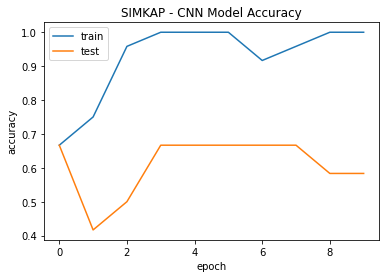

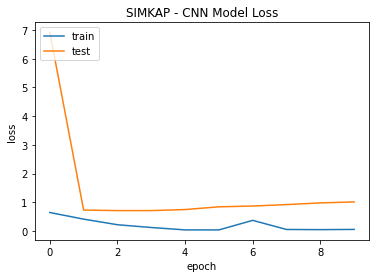

CNN SMOTE EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.60      0.75      0.67         4
      Class1       0.75      0.60      0.67         5

    accuracy                           0.67         9
   macro avg       0.68      0.68      0.67         9
weighted avg       0.68      0.67      0.67         9


CONFUSION MATRIX
 [[3 1]
 [2 3]] 

  Sensitivity    Specificity
-------------  -------------
           60             75


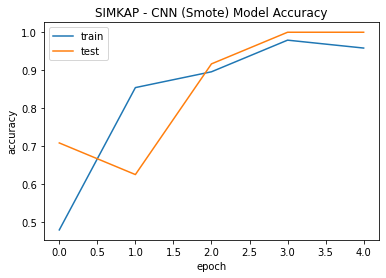

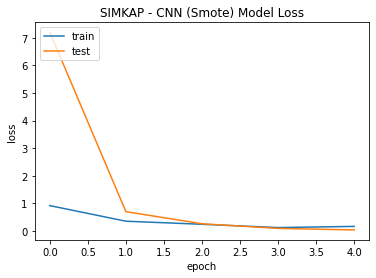

In [ ]:
print('CNN EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnn_hi,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnn_hi,'SIMKAP - CNN')

print('CNN SMOTE EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnn_hi_smote,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnn_hi_smote,'SIMKAP - CNN (Smote)')


GRU EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.75      0.75      0.75         4
      Class1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9


CONFUSION MATRIX
 [[3 1]
 [1 4]] 

  Sensitivity    Specificity
-------------  -------------
           80             75


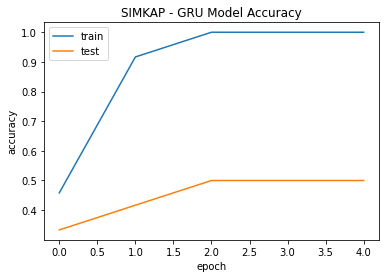

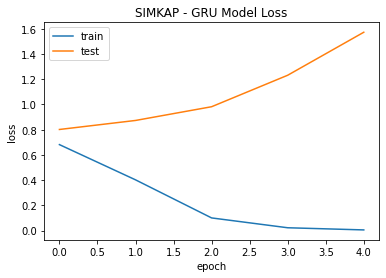

GRU SMOTE EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       1.00      0.75      0.86         4
      Class1       0.83      1.00      0.91         5

    accuracy                           0.89         9
   macro avg       0.92      0.88      0.88         9
weighted avg       0.91      0.89      0.89         9


CONFUSION MATRIX
 [[3 1]
 [0 5]] 

  Sensitivity    Specificity
-------------  -------------
          100             75


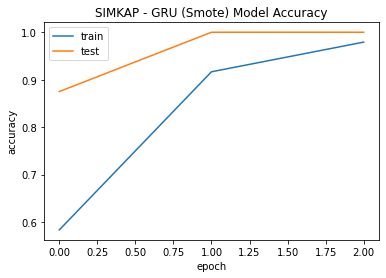

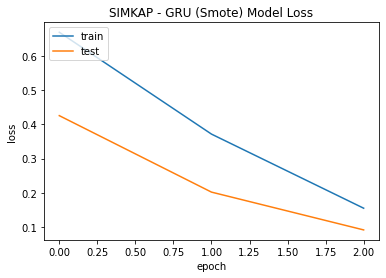

In [ ]:
print('GRU EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_gru_hi,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_gru_hi,'SIMKAP - GRU')

print('GRU SMOTE EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_gru_hi_smote,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_gru_hi_smote,'SIMKAP - GRU (Smote)')


SIMKAP - CNNGRU EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       1.00      0.50      0.67         4
      Class1       0.71      1.00      0.83         5

    accuracy                           0.78         9
   macro avg       0.86      0.75      0.75         9
weighted avg       0.84      0.78      0.76         9


CONFUSION MATRIX
 [[2 2]
 [0 5]] 

  Sensitivity    Specificity
-------------  -------------
          100             50


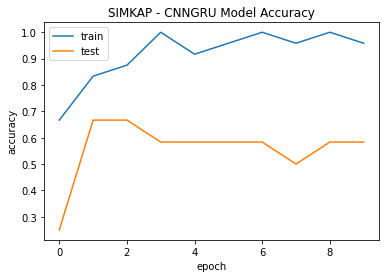

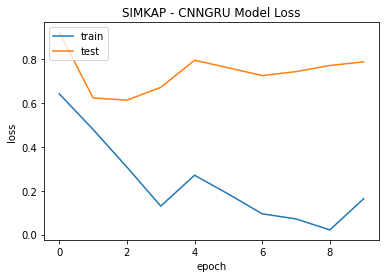

CNNGRU SMOTE EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.50      1.00      0.67         4
      Class1       1.00      0.20      0.33         5

    accuracy                           0.56         9
   macro avg       0.75      0.60      0.50         9
weighted avg       0.78      0.56      0.48         9


CONFUSION MATRIX
 [[4 0]
 [4 1]] 

  Sensitivity    Specificity
-------------  -------------
           20            100


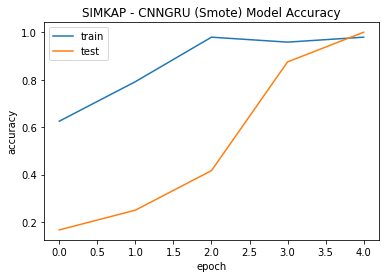

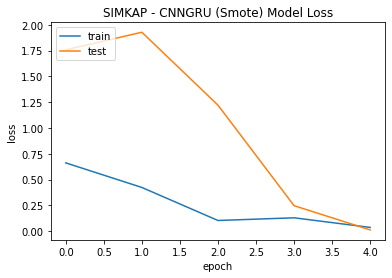

In [ ]:
print('SIMKAP - CNNGRU EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnngru_hi,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnngru_hi,'SIMKAP - CNNGRU')

print('CNNGRU SMOTE EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnngru_hi_smote,X_test_hi,y_test_hi)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnngru_hi_smote,'SIMKAP - CNNGRU (Smote)')


##### No Task classification

In [ ]:
 
#model_cnn_lo,hist_cnn_lo,accuracy = cnn_evaluate(X_train_lo,y_train_lo,X_test_lo,y_test_lo,'task',5,10)
model_cnn_lo_smote,hist_cnn_lo_smote,accuracy = cnn_evaluate(X_train_lo_SMOTE,y_train_lo_SMOTE,X_test_lo,y_test_lo,'task',5,10)
  

Epoch 1/5
5/5 [==============================] - 1s 169ms/step - loss: 0.3790 - accuracy: 0.8000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 0s 50ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 0s 51ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 0s 49ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 0s 21ms/step - loss: 0.6027 - accuracy: 0.8889


In [ ]:
#model_gru_lo,hist_gru_lo,accuracy = gru_evaluate(X_train_lo,y_train_lo,X_test_lo,y_test_lo,'task',num_epochs = 3,size = 10)
model_gru_lo,hist_gru_lo,accuracy = gru_evaluate(X_train_lo_SMOTE,y_train_lo_SMOTE,X_test_lo,y_test_lo,'task',num_epochs = 3,size = 10)


Epoch 1/3
5/5 [==============================] - 6s 220ms/step - loss: 0.5599 - accuracy: 0.6667 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 2/3
5/5 [==============================] - 0s 57ms/step - loss: 0.1182 - accuracy: 0.9778 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 3/3
2/2 [==============================] - 0s 11ms/step - loss: 0.2328 - accuracy: 0.8889


In [ ]:

#model_cnngru_lo,hist_cnngru_lo,accuracy =cnngru_evaluate(X_train_lo,y_train_lo,X_test_lo,y_test_lo,'task',num_epochs = 5,size = 20)
model_cnngru_lo,hist_cnngru_lo,accuracy =cnngru_evaluate(X_train_lo_SMOTE,y_train_lo_SMOTE,X_test_lo,y_test_lo,'task',num_epochs = 5,size = 20)


Epoch 1/5
3/3 [==============================] - 5s 383ms/step - loss: 0.6439 - accuracy: 0.6667 - val_loss: 0.9328 - val_accuracy: 0.3913
Epoch 2/5
3/3 [==============================] - 0s 65ms/step - loss: 0.2104 - accuracy: 0.9778 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 0s 67ms/step - loss: 0.1575 - accuracy: 0.9556 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 0s 68ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 1s 18ms/step - loss: 0.4652 - accuracy: 0.8889


##### NoTask Evaluation Reports

No Task -CNN EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.89      1.00      0.94         8
      Class1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


CONFUSION MATRIX
 [[8 0]
 [1 0]] 

  Sensitivity    Specificity
-------------  -------------
            0            100


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


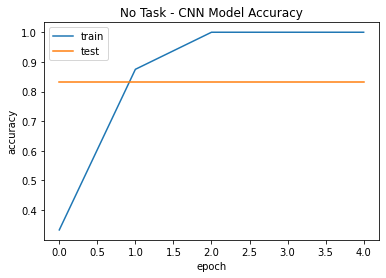

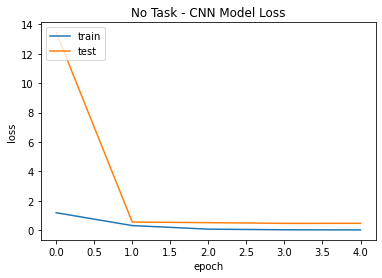

No Task - SMOTE CNN EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.89      1.00      0.94         8
      Class1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


CONFUSION MATRIX
 [[8 0]
 [1 0]] 

  Sensitivity    Specificity
-------------  -------------
            0            100


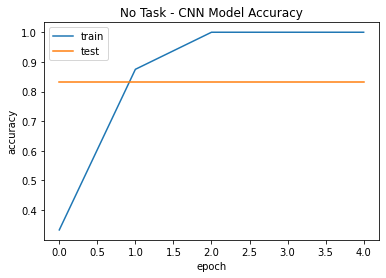

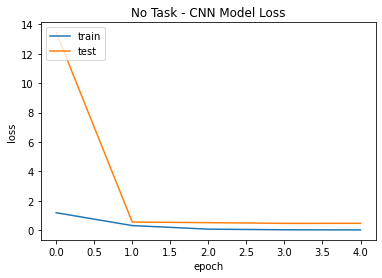

In [ ]:
print('No Task -CNN EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnn_lo,X_test_lo,y_test_lo)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnn_lo,'No Task - CNN')

print('No Task - SMOTE CNN EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnn_lo,X_test_lo,y_test_lo)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnn_lo,'No Task - CNN')

GRU EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.89      1.00      0.94         8
      Class1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


CONFUSION MATRIX
 [[8 0]
 [1 0]] 

  Sensitivity    Specificity
-------------  -------------
            0            100


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


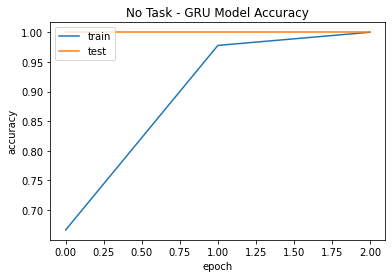

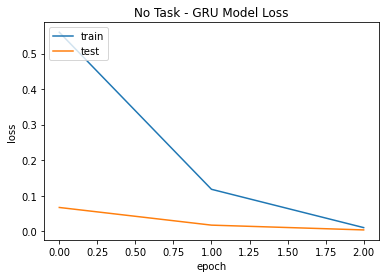

In [ ]:
print('GRU EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_gru_lo,X_test_lo,y_test_lo)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_gru_lo,'No Task - GRU')

No Task -CNNGRU EVALUATION REPORT
              precision    recall  f1-score   support

      Class0       0.89      1.00      0.94         8
      Class1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9


CONFUSION MATRIX
 [[8 0]
 [1 0]] 

  Sensitivity    Specificity
-------------  -------------
            0            100


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


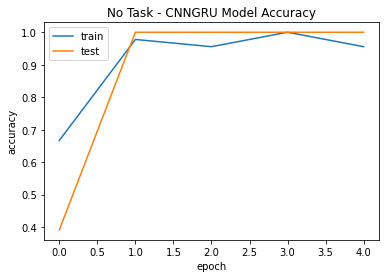

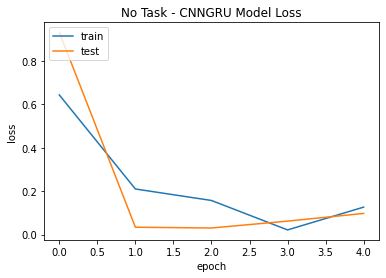

In [ ]:
print('No Task -CNNGRU EVALUATION REPORT')
y_true,y_pred = evaluation_report(model_cnngru_lo,X_test_lo,y_test_lo)
evaluation_metrics(y_true,y_pred)
plot_graph(hist_cnngru_lo,'No Task - CNNGRU')